### Try to understand the intuition behind the code

In [48]:
# Older inputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ( ModelSpec as MS, summarize )

# Newer inputs
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [49]:
data = load_data("Smarket")
data.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [50]:
data_wo = data.loc[:, "Year" : "Today"]
data_wo.corr() # To calculate the correlation

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


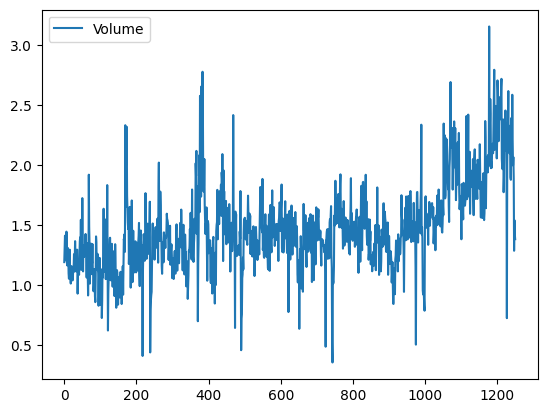

In [51]:
data.plot(y = "Volume")
plt.show() 

In [52]:
# Logistic Regression
allvars = data.columns.drop(['Today', 'Direction', 'Year'])
x = MS(allvars).fit_transform(data)
y = data.Direction == "Up"
logit_model = sm.GLM(y,x, family = sm.families.Binomial()).fit()
summarize(logit_model)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [53]:
probs = logit_model.predict()
labels = np.array(["Down"] * 1250)
labels[probs > 0.5] = "Up" 

In [54]:
confusion_table(labels, data.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [55]:
# From confusion table 
ref = np.mean(labels == data.Direction)
log_pred = (507 + 145) / len(data)
print(ref, log_pred) # Not better than anything

0.5216 0.5216


In [56]:
# Splitting the dataset
train = data.Year < 2005
data_train, data_test = data.loc[train], data.loc[~train]

# Now splitting the data sets & fitting the logistic regression
X_train, X_test = x.loc[train], x.loc[~train] 
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train , family=sm.families.Binomial()) 
results = glm_train.fit()
probs = results.predict(X_test) # Trained on model and tested on the test set

# To create the confusion table
D = data.Direction
L_train, L_test = D.loc[train], D.loc[~train]
labels = np.array(['Down']*np.shape(data_test)[0])
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [57]:
(77 + 44)/len(data_test) 
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [58]:
# We saw that lag1 and lag2 are really good so
x = MS(["Lag1", "Lag2"]).fit_transform(data)
x_train, x_test = x[train], x[~train]
y_train, y_test = y[train], y[~train]

# Fitting the logisitc regression
glm_model = sm.GLM(y_train, x_train, family = sm.families.Binomial()).fit()
preds = glm_model.predict(x_test)
labels = np.array(["Down"] * np.shape(x_test)[0])
labels[preds > 0.5] = "Up"

# Confusion Matrix
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [59]:
# Accuracy
np.mean(labels == L_test), np.mean(labels != L_test)

(0.5595238095238095, 0.44047619047619047)

In [60]:
# Linear Discriminant Analysis
lda = LDA(store_covariance = True)

# LDA automatically adds the intercept - so we need not to.
x = data.loc[:, ["Lag1", "Lag2"]]
x_train, x_test = x[train], x[~train]

lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [61]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

Mean feature values for class 1 : [ 0.04279022,  0.03389409] <br>
Mean feature values for class 2 : [-0.03954635, -0.03132544] <br>
The closer the means are for each class, the harder it is for the LDA to separate. 

In [62]:
lda.classes_

array([False,  True])

In [63]:
lda.priors_

array([0.49198397, 0.50801603])

$\hat{\pi_{False}}$ = $ 0.4919 $ <br>
$\hat{\pi_{True}}$ = $ 0.5080 $ <br>

In [64]:
# Creating the decision boundary
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

The `scalings` provide the linear combination for `Lag1` and `Lag2` which are used to create the decision boundary. Now using the scalings the equations become
${Y_i} = -0.64{Lag_1} -0.51{Lag_2} $ which is the decision boundary
If ${Y_i}$ is large, then classifier will predict market increase or vice versa. 

In [65]:
lda_pred = lda.predict(x_test)
preds = np.where(lda_pred, "Up", "Down")
confusion_table(preds, L_test)

# Classification accuracy improves : around 55%

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


#### You need to define your positives and negatives

`positives` -> `Up`
`negatives` -> `Down`

_TN (True Negatives)_ = 35 <br> 
_TP (True Positives)_ = 106 <br>
_FP (False Positives)_ = 76 -> Predicted `positive` but truth is `negative` <br>
_FN (False Negatives)_ = 35 -> Predicted `negative` but truth is `positive` <br>

#### Key metrices to track
1. $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
= \frac{35 + 106}{35 + 106 + 35 + 76} = \frac{141}{252} \approx 0.5595 \, (55.95\%)$
2. $\text{Precision}$ : Out of all `positives` how many were correct
   - $\text{Precision} = \frac{TP}{TP + FP} = \frac{106}{106 + 76} = \frac{106}{182} \approx 0.5824 \, (58.24\%)$
3. $\text{Recall}$ : Out of all `positives` how many were correctly predicted
    - $\text{Recall} = \frac{TP}{TP + FN} = \frac{106}{106 + 35} = \frac{106}{141} \approx 0.7518 \, (75.18\%)$
4. $\text{Specificity}$ : Out of all actual `negatives`, how many were correctly predicted?
   - $\text{Specificity} = \frac{TN}{TN + FP} = \frac{35}{35 + 76} = 0.31 \, (31.531\%)$

#### Inferences 
- It predicts well for the True values, considering the dataset
- It doesn't predict well for the False values


In [66]:
# Quadractic Discriminant analysis
qda = QDA(store_covariance = True)
qda.fit(x_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [67]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

$\hat{\pi_{down}} = 0.491 $ <br>
$\hat{\pi_{up}} = 0.5080 $ <br>
There is not much difference from the `LDA-Classifier` <br>
The way QDA works is that it doesn't assume same covariances for all classes, it has a class wise covariance thing

In [68]:
qda.covariance_ # Pretty similar ig 

[array([[ 1.50662277, -0.03924806],
        [-0.03924806,  1.53559498]]),
 array([[ 1.51700576, -0.02787349],
        [-0.02787349,  1.49026815]])]

In [69]:
qda_pred = qda.predict(x_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


### Metrices to track
1. $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
= \frac{30 + 121}{121 + 30 + 81 + 20} = \frac{151}{252} \approx 0.5995 \, (59.95\%)$
2. $\text{Precision} = \frac{TP}{TP + FP} = \frac{121}{121 + 81} = \frac{121}{202} \approx 0.5990 \, (59.90\%)$
3. $\text{Recall} = \frac{TP}{TP + FN} = \frac{121}{121 + 20} = \frac{121}{141} \approx 0.8581 \, (85.81\%)$
4. $\text{Specificity} = \frac{TN}{TN + FP} = \frac{30}{30 + 81} = 0.31 \approx 0.2702 (27.02\%)$

### Some Inferences 
- High recall suggests that it is good at predicting `positives` correctly
- Accuracy has improved from 55.55% to 59%, suggesting `QDA` performs well

In [70]:
## Naive Bayes - models each quantitative feature using gaussian distribution
nb = GaussianNB()
nb.fit(x_train, L_train)

GaussianNB()

In [71]:
nb.classes_, nb.class_prior_

(array(['Down', 'Up'], dtype='<U4'), array([0.49198397, 0.50801603]))

In [72]:
nb.theta_, nb.var_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([[1.50355429, 1.53246749],
        [1.51401364, 1.48732877]]))

Making sense of $\theta$
- `rows` is equal to the number of classes
- `columns` is equal to the number of features

$\theta_{Down,Lag1}$ = 0.042


In [73]:
nb_preds = nb.predict(x_test)
confusion_table(nb_preds, L_test)

# Pretty good recall for this.
# Accuracy is like : 59%, slightly lesser than QDA

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [47]:
# K Nearest Neighbors
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(x_train, L_train)

ValueError: Found input variables with inconsistent numbers of samples: [4822, 998]

In [29]:
knn1_pred = knn1.predict(x_test)
confusion_table(knn1_pred, L_test)
# 50% Accuracy, almost random guessing

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [30]:
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(x_train, L_train)
knn3_pred = knn3.predict(x_test)
confusion_table(knn3_pred, L_test)
# 53% Accuracy, not bad but doesn't improve

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


#### Caravan Dataset 
- Has around 85 predictors & 5822 individuals
- response variable `purchase` -> Indicates whether or not a individual purchases a given policy or not

Reference mark : Dataset only 6% people purchased the policy

In [31]:
data = load_data("Caravan")
data.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [32]:
purchase = data["Purchase"]
purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

$\text{Purchased} = \frac{348}{5822} \approx 0.0598 \, (5.98\%)$

In [33]:
feature_df = data.drop(columns = ["Purchase"])

The scales of the data would be different & `KNN` uses distance, so a distance of $1000 would not be the same as a distance of 50 years. To tackle this problem, we try to normalize the variables or standardize them with `mean` = 0 and `std` = 0

In [34]:
scaler = StandardScaler(with_mean = True, with_std = True, copy = True)
scaler.fit(feature_df)
x_std = scaler.transform(feature_df)

# Just making sure
feature_std = pd.DataFrame(x_std, columns = feature_df.columns)
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [35]:
# So this function usually returns a tuple so we need to decouple the tuple, random_state = 0 -> for reproducbility
(x_train, x_test, y_train, y_test) = train_test_split(feature_std,purchase, test_size = 1000, random_state = 0)

knn1 = KNeighborsClassifier(n_neighbors = 1)
knn_pred = knn1.fit(x_train, y_train).predict(x_test)
confusion_table(knn_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [36]:
for k in range(1,6) : 
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_pred = knn.fit(x_train, y_train).predict(x_test)
    c = confusion_table(knn_pred, y_test)
    pred = c.loc["Yes"].sum()
    did_buy = c.loc["Yes", "Yes"]
    print(f"K = {k}, predicted to buy : {pred}, buy : {did_buy} with accuracy : {did_buy/pred:.2f}")

K = 1, predicted to buy : 62, buy : 9 with accuracy : 0.15
K = 2, predicted to buy : 6, buy : 1 with accuracy : 0.17
K = 3, predicted to buy : 20, buy : 3 with accuracy : 0.15
K = 4, predicted to buy : 4, buy : 0 with accuracy : 0.00
K = 5, predicted to buy : 7, buy : 1 with accuracy : 0.14


### Linear and poisson regression on bike share data

In [37]:
data = load_data("Bikeshare")
data.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


In [38]:
data.shape

(8645, 15)

Around 15 Columns and 8645 Entries ; To fit a linear regression on
- mnth
- hr
- workingday
- temp
- weathersit

In [39]:
x = MS(["mnth", "hr", "workingday", "temp", "weathersit"]).fit_transform(data)
y = data['bikers']
model = sm.OLS(y,x).fit()
summarize(model)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


For `ceterius paribus` February $\approx$ 7 riders more than January

In [40]:
# with effect encoding
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')

In [41]:
x = MS([hr_encode, mnth_encode, 'workingday', 'temp', 'weathersit']).fit_transform(data)
model = sm.OLS(y,x).fit()
summarize(model)

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
hr[0],-96.1420,3.955,-24.307,0.000
hr[1],-110.7213,3.966,-27.916,0.000
hr[2],-117.7212,4.016,-29.310,0.000
hr[3],-127.2828,4.081,-31.191,0.000
hr[4],-133.0495,4.117,-32.319,0.000
hr[5],-120.2775,4.037,-29.794,0.000
hr[6],-75.5424,3.992,-18.925,0.000
hr[7],23.9511,3.969,6.035,0.000
hr[8],127.5199,3.950,32.284,0.000


The coefficients with $\textbf{Effect Encoding}$ always sum up to be zero, for Jan -46.0871 can be interpreted as the difference from the mean level to be around -46.0871, like typically $\approx 46$ less riders compared to yearly average <br><br> The choice of encoding should not matter, interpretation difference is there just :
- Relative encoding
- Effect encoding

In [42]:
s = summarize(model)
coef_month = s[s.index.str.contains('mnth')]['coef']
coef_month["mnth[Dec]"] = -coef_month.sum()

coef_hour = s[s.index.str.contains('hr')]['coef']
coef_hour['hr[23]'] = -coef_hour.sum()

/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_50500/2910915546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_month["mnth[Dec]"] = -coef_month.sum()
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_50500/2910915546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_hour['hr[23]'] = -coef_hour.sum()


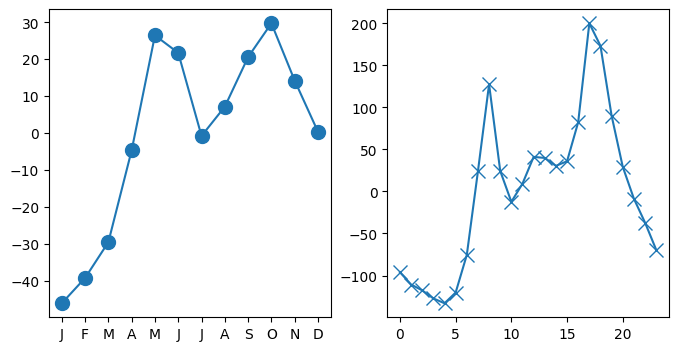

In [43]:
fig, ax = plt.subplots(1,2,figsize = (8,4))
x_month = np.arange(coef_month.shape[0])
ax[0].plot(x_month, coef_month, marker='o', ms=10) 
ax[0].set_xticks(x_month)
ax[0].set_xticklabels([l[5] for l in coef_month.index])

x_hour = np.arange(coef_hour.shape[0])
ax[1].plot(x_hour, coef_hour, marker = 'x', ms = 10)
plt.show()

In [44]:
# Fitting poisson regression instead
model_pois = sm.GLM(y, x, family = sm.families.Poisson()).fit()
s = summarize(model_pois)

coef_pois_month = s[s.index.str.contains("hr")]["coef"]
coef_pois_hour = s[s.index.str.contains("mnth")]["coef"]
coef_pois_hour["hr[23]"] = -coef_pois_hour.sum()
coef_pois_month["mnth[Dec]"] = -coef_pois_month.sum()

/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_50500/1152280172.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_pois_hour["hr[23]"] = -coef_pois_hour.sum()
/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_50500/1152280172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coef_pois_month["mnth[Dec]"] = -coef_pois_month.sum()


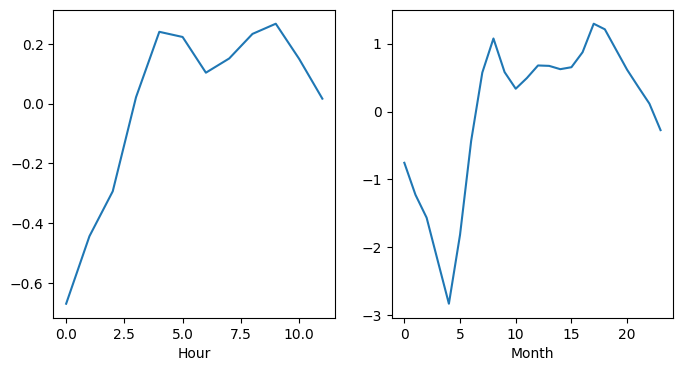

In [45]:
fig, ax = plt.subplots(1,2,figsize = (8,4))
ax[0].plot(np.arange(coef_pois_hour.shape[0]), coef_pois_hour)
ax[0].set_xlabel("Hour")
ax[1].plot(np.arange(coef_pois_month.shape[0]), coef_pois_month)
ax[1].set_xlabel("Month")
plt.show()

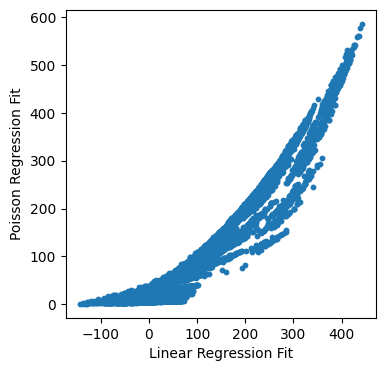

AttributeError: 'OLSResults' object has no attribute 'Rsquare'

In [46]:
# comparing the fitted values
fig,ax = plt.subplots(figsize = (4,4))
ax.scatter(model.fittedvalues, model_pois.fittedvalues, s = 10)
ax.set_xlabel('Linear Regression Fit')
ax.set_ylabel('Poisson Regression Fit')
plt.show()
model.Rsquare